In [27]:
# Imports and Constants
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [28]:
# Import your Experiment class and related entities
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")

# Constants
data_folder = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
FRAME_RATE = 30  # Hz


In [29]:
# Experiment Loading and Grouping Functions
def load_experiments(data_folder):
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            path = os.path.join(data_folder, file)
            with open(path, 'rb') as f:
                exp = pickle.load(f)
                experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments


def get_sapap_genotype(geno_str):
    if "Sapap(" in geno_str:
        start = geno_str.find("Sapap(") + len("Sapap(")
        end = geno_str.find(")", start)
        return geno_str[start:end]
    return None


def group_experiments_by_genotype(experiments):
    WT, KO = [], []
    for exp in experiments:
        geno = get_sapap_genotype(exp.Genotype)
        if geno == 'WT':
            WT.append(exp)
        elif geno == 'KO':
            KO.append(exp)
        else:
            print(f"Warning: unknown genotype for {exp.Mouse_id}")
    print(f"WT mice: {len(WT)}, KO mice: {len(KO)}")
    return WT, KO


In [30]:
# Bout Detection and Pre-Bout Filtering
def detect_medium_bouts(exps, min_sec, max_sec):
    min_f, max_f = min_sec*FRAME_RATE, max_sec*FRAME_RATE
    total = 0
    bouts = {}
    for exp in exps:
        ann = exp.Grooming_annotations or []
        valid = [(s,e) for s,e in ann if min_f <= (e-s) <= max_f]
        bouts[exp.Mouse_id] = valid
        total += len(valid)
    print(f"Valid bouts ({min_sec}-{max_sec}s): {total}")
    return total, bouts


def filter_by_pre_activity(exps, bouts_dict, pre_sec):
    pre_f = pre_sec*FRAME_RATE
    filt_bouts = {}
    filt_traces = {}
    for exp in exps:
        ann = exp.Grooming_annotations or []
        valid = bouts_dict.get(exp.Mouse_id, [])
        good, traces = [], []
        for s,e in valid:
            has_pre = any((oe > s-pre_f) and (oe <= s) for os,oe in ann if (os,oe)!=(s,e))
            if not has_pre:
                good.append((s,e))
                start = max(0, s-pre_f)
                trace, t = exp.get_gcamp_data_Z_score(start, e)
                traces.append((trace, t))
        filt_bouts[exp.Mouse_id] = good
        filt_traces[exp.Mouse_id] = traces
        print(f"Mouse {exp.Mouse_id}: {len(good)} bouts after filtering")
    return filt_bouts, filt_traces


In [31]:
# Alignment and Averaging Functions
def align_traces(traces_dict, bouts_dict):
    aligned = {}
    for m, traces in traces_dict.items():
        aligned[m] = []
        for (trace, t), (s,e) in zip(traces, bouts_dict.get(m, [])):
            aligned[m].append((trace, t - s/FRAME_RATE))
    return aligned


def compute_avg_traces(aligned, common_t):
    mouse_avg, counts = {}, {}
    all_tr = []
    for m, trs in aligned.items():
        if not trs:
            continue
        its = [np.interp(common_t, t, tr) for tr,t in trs]
        arr = np.vstack(its)
        avg = arr.mean(0)
        std = arr.std(0)
        sem = std/np.sqrt(arr.shape[0])
        mouse_avg[m] = {'avg':avg, 'std':std, 'sem':sem}
        counts[m] = arr.shape[0]
        all_tr.extend(its)
    grp = np.vstack(all_tr) if all_tr else np.array([])
    if grp.size:
        gavg = grp.mean(0); gstd = grp.std(0); gsem = gstd/np.sqrt(grp.shape[0])
    else:
        gavg=gstd=gsem=None
    return mouse_avg, counts, gavg, gstd, gsem

In [32]:
# Local Z-Score Computation
def compute_local_average_zscore(aligned, common_t, window_start, window_end):
    # mask = (common_t>=window_start) # basline is calculated for the PRE_BOUT_WINDOW
    mask = (common_t>=window_start)&(common_t<=window_end)  # basline is calculated for the PRE_BOUT + BOUT_WINDOW
    local = {}
    for m, trs in aligned.items():
        its = [np.interp(common_t, t, tr) for tr,t in trs]
        arr = np.vstack(its)
        avg = arr.mean(0)
        baseline = avg[mask].mean()
        local[m] = avg - baseline*0.9
    all_loc = np.vstack(list(local.values()))
    grp_avg = all_loc.mean(0)
    grp_sem = all_loc.std(0, ddof=1)/np.sqrt(all_loc.shape[0])
    return local, grp_avg, grp_sem

In [33]:
# Plotting Function
def plot_traces(common_t, mouse_data, group_avg, group_sem, title, color, ylabel="Z-score", show_ind=True):
    plt.figure(figsize=(12,6))
    if show_ind:
        for m, tr in mouse_data.items():
            plt.plot(common_t, tr, color='gray', alpha=0.5)
    plt.plot(common_t, group_avg, color=color, linewidth=2, label=title)
    plt.fill_between(common_t, group_avg-group_sem, group_avg+group_sem, color=color, alpha=0.3)
    plt.axvline(0, linestyle='--', color='k')
    plt.xlabel('Time (s)'); plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(); plt.grid(True)
    plt.show()

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Total .pkl files loaded: 13
WT mice: 5, KO mice: 8
Valid bouts (2-300s): 147
Valid bouts (2-300s): 286
Mouse M329: 9 bouts after filtering
Mouse M344: 11 bouts after filtering
Mouse M354: 26 bouts after filtering
Mouse M365: 6 bouts after filtering
Mouse M511: 8 bouts after filtering
Mouse M338: 10 bouts after filtering
Mouse M352: 18 bouts after filtering
Mouse M406: 14 bouts after filtering
Mouse M407: 22 bouts after filtering
Mouse M416: 13 bouts after filtering
Mouse M420: 8 bouts after filtering
Mouse M501: 6 bouts after filtering
Mouse M508: 13 bouts after filtering


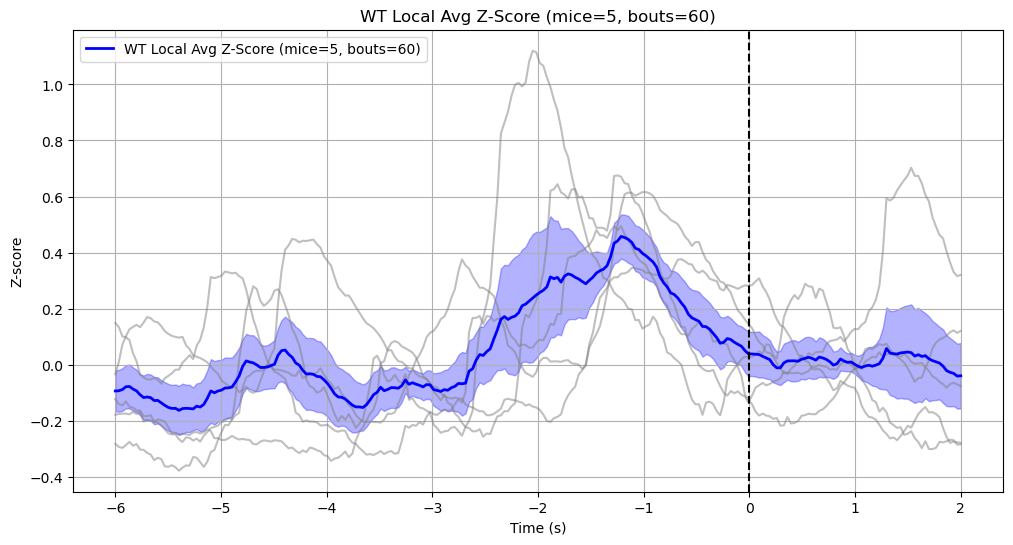

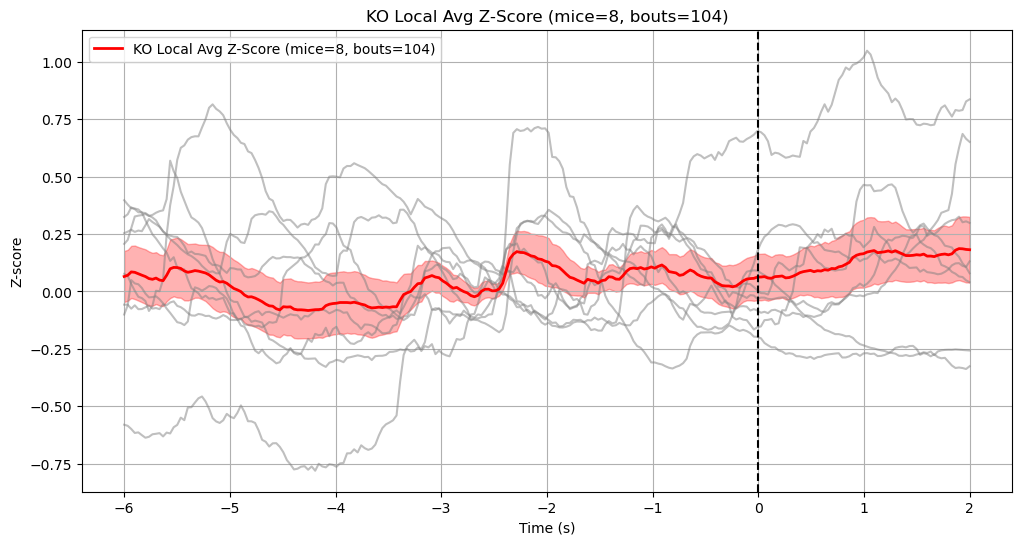

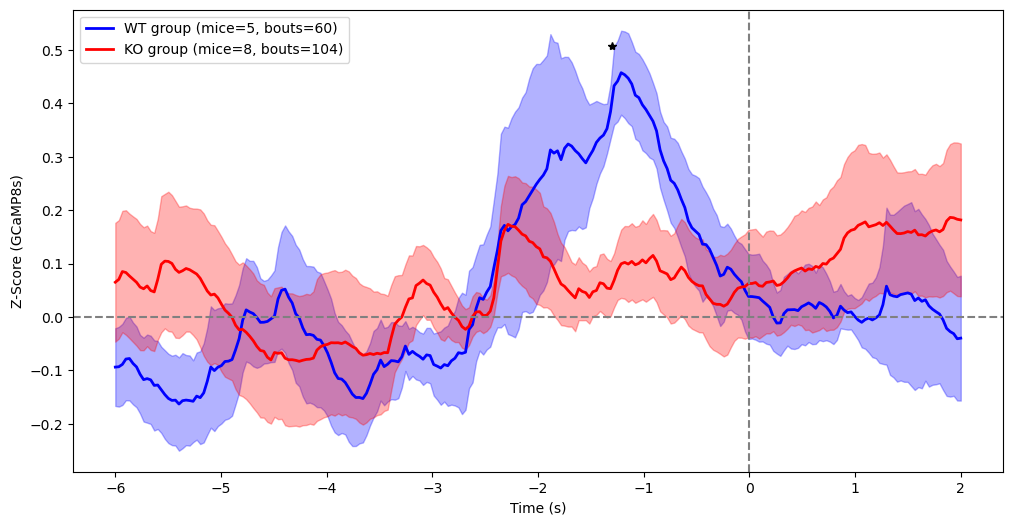

In [34]:
# Main Execution
if __name__ == '__main__':
    # Load and group
    exps = load_experiments(data_folder)
    for exp in exps:
        exp.smooth_grooming_bouts_generator(threshold=45)
    WT, KO = group_experiments_by_genotype(exps)
    exp_dict = {e.Mouse_id: e for e in exps}

    # Settings
    MIN_LEN, MAX_LEN = 2, 300
    PRE_TIME = 6
    common_t = np.linspace(-PRE_TIME, MIN_LEN, int((PRE_TIME+MIN_LEN)*FRAME_RATE))

    # Raw analysis
    _, raw_bouts_WT = detect_medium_bouts(WT, MIN_LEN, MAX_LEN)
    _, raw_bouts_KO = detect_medium_bouts(KO, MIN_LEN, MAX_LEN)
    fb_WT, ft_WT = filter_by_pre_activity(WT, raw_bouts_WT, PRE_TIME)
    fb_KO, ft_KO = filter_by_pre_activity(KO, raw_bouts_KO, PRE_TIME)
    al_WT = align_traces(ft_WT, fb_WT)
    al_KO = align_traces(ft_KO, fb_KO)

    # Compute local z-score
    loc_WT, lgavg_WT, lgsem_WT = compute_local_average_zscore(al_WT, common_t, -PRE_TIME, MIN_LEN)
    loc_KO, lgavg_KO, lgsem_KO = compute_local_average_zscore(al_KO, common_t, -PRE_TIME, MIN_LEN)

    # Statistical test in 0.5s bins
    bin_size = int(0.2 * FRAME_RATE)
    wt_mat = np.vstack(list(loc_WT.values()))
    ko_mat = np.vstack(list(loc_KO.values()))
    n_bins = wt_mat.shape[1] // bin_size
    p_vals = []
    bin_indices = []
    for i in range(n_bins):
        start = i * bin_size
        end = start + bin_size
        wt_bin_avg = wt_mat[:, start:end].mean(axis=1)
        ko_bin_avg = ko_mat[:, start:end].mean(axis=1)
        _, p = ttest_ind(wt_bin_avg, ko_bin_avg, equal_var=False)
        p_vals.append(p)
        bin_indices.append((start, end))

    # # Statistical test in 0.5s bins using Mann–Whitney U
    # p_vals = []
    # bin_indices = []
    # for i in range(n_bins):
    #     start = i * bin_size
    #     end   = start + bin_size
    #     wt_bin_avg = wt_mat[:, start:end].mean(axis=1)
    #     ko_bin_avg = ko_mat[:, start:end].mean(axis=1)
    #     res = mannwhitneyu(wt_bin_avg, ko_bin_avg, alternative='two-sided')
    #     p_vals.append(res.pvalue)
    #     bin_indices.append((start, end))    

    # FDR correction & legend info
    _, p_corr, _, _ = multipletests(p_vals, method='fdr_bh')
    sig_mask = p_corr < 0.1
    wt_n_mice = len(loc_WT)
    wt_n_traces = sum(len(trs) for trs in al_WT.values())
    ko_n_mice = len(loc_KO)
    ko_n_traces = sum(len(trs) for trs in al_KO.values())


    # 1) Per‐group plots
    wt_n_mice   = len(loc_WT)
    wt_n_traces = sum(len(trs) for trs in al_WT.values())
    plot_traces(
        common_t,
        loc_WT,
        lgavg_WT,
        lgsem_WT,
        title=f"WT Local Avg Z-Score (mice={wt_n_mice}, bouts={wt_n_traces})",
        color='blue'
    )

    ko_n_mice   = len(loc_KO)
    ko_n_traces = sum(len(trs) for trs in al_KO.values())
    plot_traces(
        common_t,
        loc_KO,
        lgavg_KO,
        lgsem_KO,
        title=f"KO Local Avg Z-Score (mice={ko_n_mice}, bouts={ko_n_traces})",
        color='red'
    )

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(common_t, lgavg_WT, color='blue', linewidth=2,
             label=f"WT group (mice={wt_n_mice}, bouts={wt_n_traces})")
    plt.fill_between(common_t, lgavg_WT-lgsem_WT, lgavg_WT+lgsem_WT, color='blue', alpha=0.3)
    plt.plot(common_t, lgavg_KO, color='red', linewidth=2,
             label=f"KO group (mice={ko_n_mice}, bouts={ko_n_traces})")
    plt.fill_between(common_t, lgavg_KO-lgsem_KO, lgavg_KO+lgsem_KO, color='red', alpha=0.3)
    for (start, end), sig in zip(bin_indices, sig_mask):
        if sig:
            center_time = common_t[start:end].mean()
            ymax = max(lgavg_WT[start:end].max(), lgavg_KO[start:end].max()) + 0.05
            plt.plot(center_time, ymax, '*', color='black')
    plt.axvline(0, linestyle='--', color='grey')
    plt.axhline(0, linestyle='--', color='grey')
    plt.xlabel('Time (s)')
    plt.ylabel('Z-Score (GCaMP8s)')
    #plt.title('Combined WT vs KO Local Average Z-Score (0.5s binning, FDR-corrected)')
    plt.legend()
    #plt.grid(True)
    plt.show()

In [35]:
# %%
# Post-Hoc Summary of Bin Differences and p-values
print("Bin	TimeRange	MeanDiff(WT-KO)	P_uncorrected	P_corrected")
for idx, (start, end) in enumerate(bin_indices):
    wt_mean = wt_mat[:, start:end].mean()
    ko_mean = ko_mat[:, start:end].mean()
    diff = wt_mean - ko_mean
    p_unc = p_vals[idx]
    p_cor = p_corr[idx]
    time_range = f"{common_t[start]:.2f}-{common_t[end-1]:.2f}s"
    print(f"{idx}	{time_range}	{diff:.3f}	{p_unc:.3g}	{p_cor:.3g}")

Bin	TimeRange	MeanDiff(WT-KO)	P_uncorrected	P_corrected
0	-6.00--5.83s	-0.162	0.26	0.8
1	-5.80--5.63s	-0.168	0.253	0.8
2	-5.60--5.43s	-0.240	0.136	0.8
3	-5.40--5.23s	-0.242	0.125	0.8
4	-5.20--5.03s	-0.167	0.332	0.839
5	-5.00--4.83s	-0.074	0.654	0.872
6	-4.79--4.63s	0.044	0.783	0.891
7	-4.59--4.43s	0.081	0.595	0.839
8	-4.39--4.23s	0.097	0.592	0.839
9	-4.19--4.03s	0.028	0.88	0.927
10	-3.99--3.82s	-0.053	0.765	0.891
11	-3.79--3.62s	-0.083	0.608	0.839
12	-3.59--3.42s	-0.031	0.824	0.891
13	-3.39--3.22s	-0.073	0.492	0.839
14	-3.19--3.02s	-0.130	0.145	0.8
15	-2.99--2.82s	-0.114	0.241	0.8
16	-2.79--2.62s	-0.042	0.714	0.891
17	-2.59--2.42s	0.035	0.764	0.891
18	-2.38--2.22s	0.009	0.966	0.966
19	-2.18--2.02s	0.074	0.766	0.891
20	-1.98--1.82s	0.185	0.451	0.839
21	-1.78--1.62s	0.262	0.185	0.8
22	-1.58--1.41s	0.262	0.05	0.5
23	-1.38--1.21s	0.331	0.00189	0.0757
24	-1.18--1.01s	0.325	0.014	0.28
25	-0.98--0.81s	0.248	0.0407	0.5
26	-0.78--0.61s	0.160	0.208	0.8
27	-0.58--0.41s	0.095	0.494	0.839
28	-0.38-

In [36]:
def compute_local_median_zscore(aligned, common_t, window_start, window_end):
    """
    For each mouse, compute the median trace across bouts, 
    subtract the baseline median over [window_start, window_end],
    then return per-mouse corrected traces plus group median and sem.
    """

    mask = (common_t >= window_start) & (common_t <= window_end)
    local_med = {}
    for m, trs in aligned.items():
        # interpolate each bout onto common_t
        its = [np.interp(common_t, t, tr) for tr, t in trs]
        if not its:
            continue
        arr = np.vstack(its)  # shape (n_bouts, n_timepoints)
        med = np.median(arr, axis=0)
        baseline = np.median(med[mask])
        local_med[m] = med - baseline

    # stack across mice
    all_loc = np.vstack(list(local_med.values()))
    grp_med = np.median(all_loc, axis=0)
    grp_sem = all_loc.std(0, ddof=1) / np.sqrt(all_loc.shape[0])

    return local_med, grp_med, grp_sem

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Total .pkl files loaded: 13
WT mice: 5, KO mice: 8
Valid bouts (2-300s): 147
Valid bouts (2-300s): 286
Mouse M329: 9 bouts after filtering
Mouse M344: 11 bouts after filtering
Mouse M354: 26 bouts after filtering
Mouse M365: 6 bouts after filtering
Mouse M511: 8 bouts after filtering
Mouse M338: 10 bouts after filtering
Mouse M352: 18 bouts after filtering
Mouse M406: 14 bouts after filtering
Mouse M407: 22 bouts after filtering
Mouse M416: 13 bouts after filtering
Mouse M420: 8 bouts after filtering
Mouse M501: 6 bouts after filtering
Mouse M508: 13 bouts after filtering


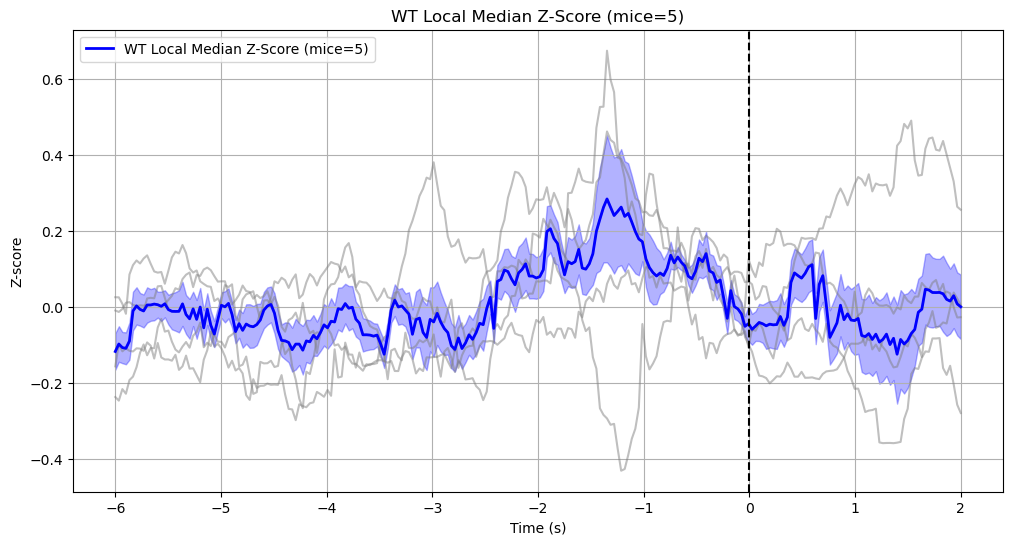

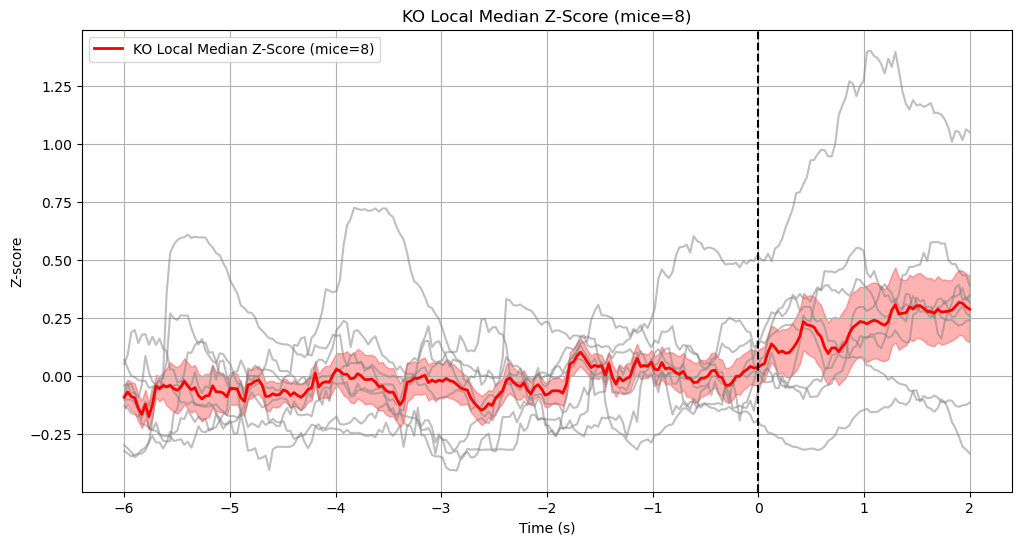

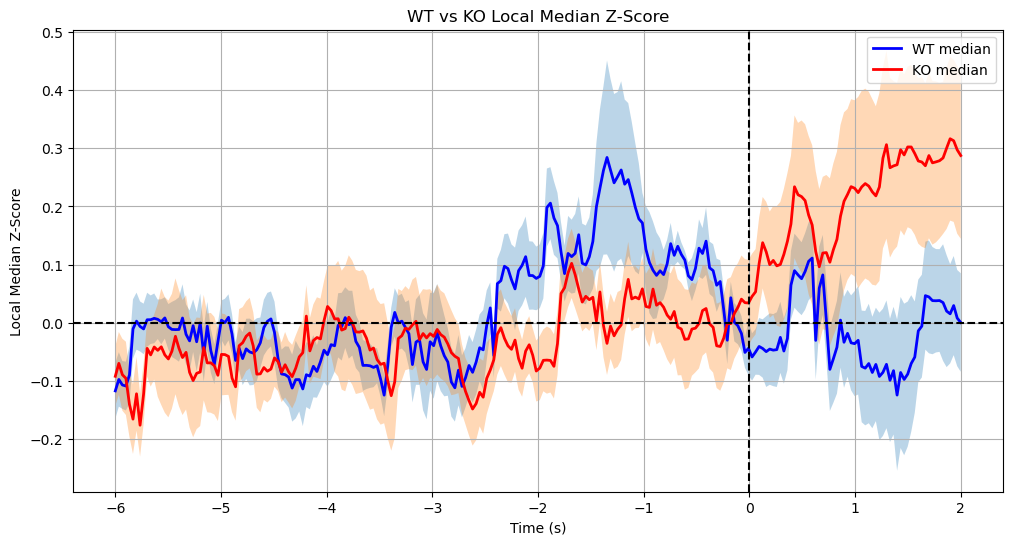

In [37]:
# Main Execution
if __name__ == '__main__':
    # Load and group
    exps = load_experiments(data_folder)
    for exp in exps:
        exp.smooth_grooming_bouts_generator(threshold=45)
    WT, KO = group_experiments_by_genotype(exps)
    exp_dict = {e.Mouse_id: e for e in exps}

    # Settings
    MIN_LEN, MAX_LEN = 2, 300
    PRE_TIME = 6
    common_t = np.linspace(-PRE_TIME, MIN_LEN, int((PRE_TIME+MIN_LEN)*FRAME_RATE))

    # Raw analysis
    _, raw_bouts_WT = detect_medium_bouts(WT, MIN_LEN, MAX_LEN)
    _, raw_bouts_KO = detect_medium_bouts(KO, MIN_LEN, MAX_LEN)
    fb_WT, ft_WT = filter_by_pre_activity(WT, raw_bouts_WT, PRE_TIME)
    fb_KO, ft_KO = filter_by_pre_activity(KO, raw_bouts_KO, PRE_TIME)
    al_WT = align_traces(ft_WT, fb_WT)
    al_KO = align_traces(ft_KO, fb_KO)

    # now run for WT and KO
    loc_med_WT, mgavg_WT, mgsem_WT = compute_local_median_zscore(al_WT, common_t, -PRE_TIME, MIN_LEN)
    loc_med_KO, mgavg_KO, mgsem_KO = compute_local_median_zscore(al_KO, common_t, -PRE_TIME, MIN_LEN)

    # Statistical test in 0.5s bins
    bin_size = int(0.2 * FRAME_RATE)
    wt_mat = np.vstack(list(loc_med_WT.values()))
    ko_mat = np.vstack(list(loc_med_KO.values()))
    n_bins = wt_mat.shape[1] // bin_size

    p_vals = []
    bin_indices = []
    for i in range(n_bins):
        start = i * bin_size
        end   = start + bin_size
        wt_bin_avg = wt_mat[:, start:end].mean(axis=1)
        ko_bin_avg = ko_mat[:, start:end].mean(axis=1)
        _, p = ttest_ind(wt_bin_avg, ko_bin_avg, equal_var=False)
        p_vals.append(p)
        bin_indices.append((start, end))

    # FDR correction & legend info
    _, p_corr, _, _ = multipletests(p_vals, method='fdr_bh')
    sig_mask = p_corr < 0.1
    wt_n_mice = len(loc_WT)
    wt_n_traces = sum(len(trs) for trs in al_WT.values())
    ko_n_mice = len(loc_KO)
    ko_n_traces = sum(len(trs) for trs in al_KO.values())


    #plot group‐specific median traces
    plot_traces(
    common_t,
    loc_med_WT,
    mgavg_WT,
    mgsem_WT,
    title=f"WT Local Median Z-Score (mice={len(loc_med_WT)})",
    color='blue'
    )

    plot_traces(
        common_t,
        loc_med_KO,
        mgavg_KO,
        mgsem_KO,
        title=f"KO Local Median Z-Score (mice={len(loc_med_KO)})",
        color='red'
    )

    # combined median comparison
    plt.figure(figsize=(12,6))
    plt.plot(common_t, mgavg_WT, linewidth=2, label='WT median', color='blue')
    plt.fill_between(common_t, mgavg_WT-mgsem_WT, mgavg_WT+mgsem_WT, alpha=0.3)
    plt.plot(common_t, mgavg_KO, linewidth=2, label='KO median', color='red')
    plt.fill_between(common_t, mgavg_KO-mgsem_KO, mgavg_KO+mgsem_KO, alpha=0.3)
    plt.axvline(0, linestyle='--', color='k')
    plt.axhline(0, linestyle='--', color='k')
    plt.xlabel('Time (s)')
    plt.ylabel('Local Median Z-Score')
    plt.title('WT vs KO Local Median Z-Score')
    plt.legend()
    plt.grid(True)
    plt.show()


In [38]:
# %% Post-Hoc Summary of Bin Differences and p-values
wt_mat = np.vstack(list(loc_med_WT.values()))   # ← these two lines aren’t strictly needed again here
ko_mat = np.vstack(list(loc_med_KO.values()))   #    since they haven’t changed, but harmless if you leave them
print("Bin\tTimeRange\tMeanDiff(WT-KO)\tP_uncorrected\tP_corrected")
for idx, (start, end) in enumerate(bin_indices):
    wt_mean    = wt_mat[:, start:end].mean()
    ko_mean    = ko_mat[:, start:end].mean()
    diff       = wt_mean - ko_mean
    p_unc      = p_vals[idx]
    p_cor      = p_corr[idx]
    time_range = f"{common_t[start]:.2f}-{common_t[end-1]:.2f}s"
    print(f"{idx}\t{time_range}\t{diff:.3f}\t{p_unc:.3g}\t{p_cor:.3g}")


Bin	TimeRange	MeanDiff(WT-KO)	P_uncorrected	P_corrected
0	-6.00--5.83s	0.041	0.582	0.803
1	-5.80--5.63s	0.087	0.226	0.695
2	-5.60--5.43s	-0.012	0.91	0.927
3	-5.40--5.23s	-0.039	0.73	0.913
4	-5.20--5.03s	-0.013	0.889	0.927
5	-5.00--4.83s	0.007	0.927	0.927
6	-4.79--4.63s	-0.013	0.875	0.927
7	-4.59--4.43s	0.022	0.76	0.917
8	-4.39--4.23s	-0.028	0.728	0.913
9	-4.19--4.03s	-0.075	0.374	0.787
10	-3.99--3.82s	-0.067	0.532	0.793
11	-3.79--3.62s	-0.091	0.454	0.789
12	-3.59--3.42s	-0.101	0.373	0.787
13	-3.39--3.22s	-0.013	0.888	0.927
14	-3.19--3.02s	0.031	0.78	0.917
15	-2.99--2.82s	0.082	0.448	0.789
16	-2.79--2.62s	0.053	0.519	0.793
17	-2.59--2.42s	0.060	0.448	0.789
18	-2.38--2.22s	0.094	0.282	0.711
19	-2.18--2.02s	0.142	0.107	0.655
20	-1.98--1.82s	0.197	0.0334	0.655
21	-1.78--1.62s	0.113	0.18	0.655
22	-1.58--1.41s	0.102	0.344	0.787
23	-1.38--1.21s	0.200	0.271	0.711
24	-1.18--1.01s	0.080	0.535	0.793
25	-0.98--0.81s	0.056	0.569	0.803
26	-0.78--0.61s	0.057	0.51	0.793
27	-0.58--0.41s	0.041	0.65	0.86


=== Female vs Male (Average-based) ===
Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Total .pkl files loaded: 13
Female mice: 9, Male mice: 4
Valid bouts (2-300s): 329
Valid bouts (2-300s): 104
Mouse M338: 10 bouts after filtering
Mouse M344: 11 bouts after filtering
Mouse M354: 26 bouts after filtering
Mouse M365: 6 bouts after filtering
Mouse M406: 14 bouts after filtering
Mouse M407: 22 bouts after filtering
Mouse M420: 8 bouts after filtering
Mouse M501: 6 bouts after filtering
Mouse M508: 13 bouts after filtering
Mouse M329: 9 bouts after filtering
Mouse M352: 18 bouts after filtering
Mouse M416: 13 bouts after filtering
Mouse M5

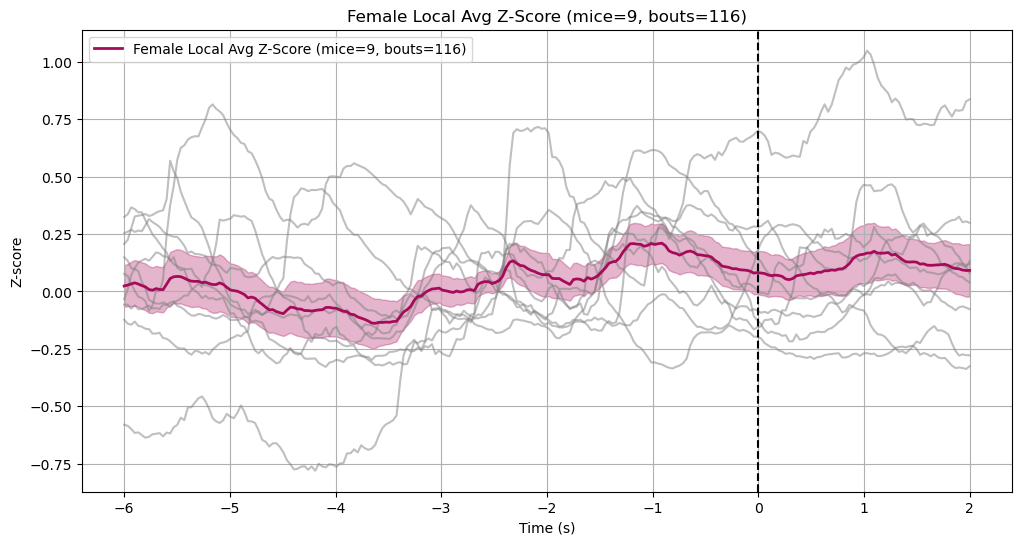

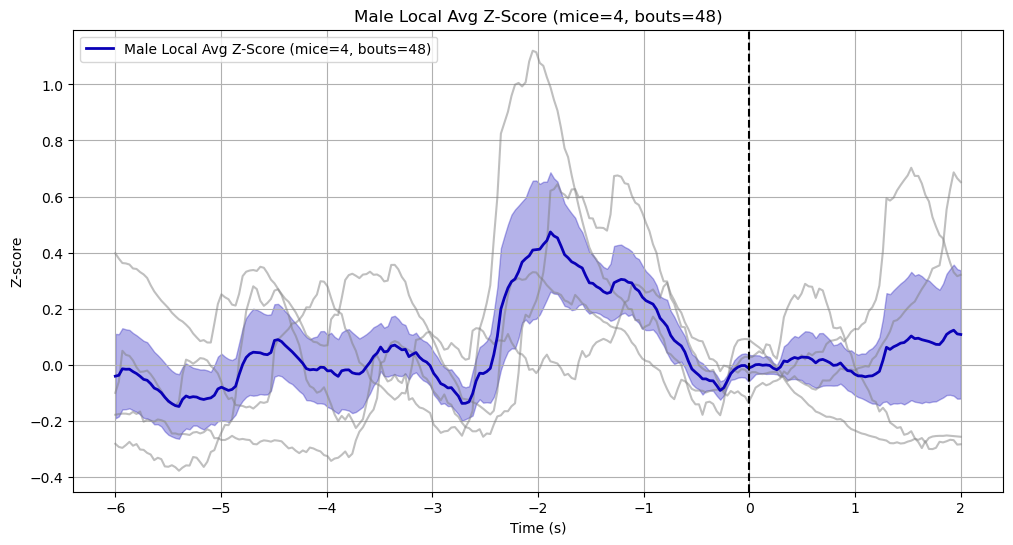

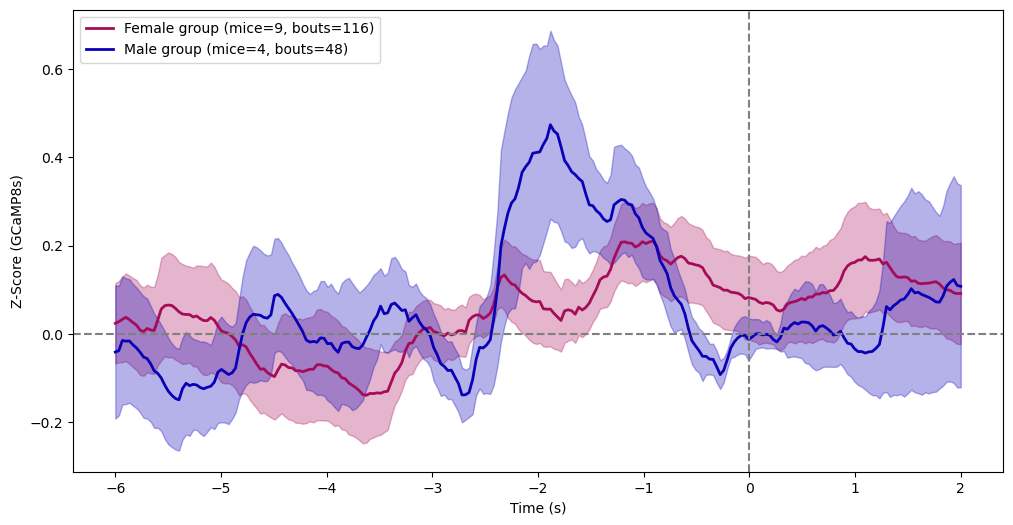

Bin	TimeRange	MeanDiff(Female-Male)	P_uncorrected	P_corrected
0	-6.00--5.80s	0.055	0.761	0.892
1	-5.77--5.56s	0.089	0.607	0.892
2	-5.53--5.33s	0.187	0.282	0.859
3	-5.30--5.10s	0.155	0.343	0.859
4	-5.06--4.86s	0.094	0.564	0.892
5	-4.83--4.63s	-0.070	0.701	0.892
6	-4.59--4.39s	-0.146	0.404	0.859
7	-4.36--4.16s	-0.099	0.553	0.892
8	-4.13--3.92s	-0.057	0.753	0.892
9	-3.89--3.69s	-0.082	0.659	0.892
10	-3.66--3.46s	-0.157	0.296	0.859
11	-3.42--3.22s	-0.131	0.306	0.859
12	-3.19--2.99s	-0.011	0.911	0.945
13	-2.95--2.75s	0.081	0.388	0.859
14	-2.72--2.52s	0.119	0.19	0.859
15	-2.49--2.28s	-0.024	0.899	0.945
16	-2.25--2.05s	-0.260	0.356	0.859
17	-2.02--1.82s	-0.383	0.171	0.859
18	-1.78--1.58s	-0.325	0.139	0.859
19	-1.55--1.35s	-0.181	0.175	0.859
20	-1.31--1.11s	-0.101	0.504	0.892
21	-1.08--0.88s	-0.030	0.827	0.937
22	-0.85--0.64s	0.056	0.636	0.892
23	-0.61--0.41s	0.173	0.115	0.859
24	-0.38--0.18s	0.171	0.0893	0.859
25	-0.14-0.06s	0.092	0.369	0.859
26	0.09-0.29s	0.071	0.466	0.892
27	0.33-0.53s	0.05

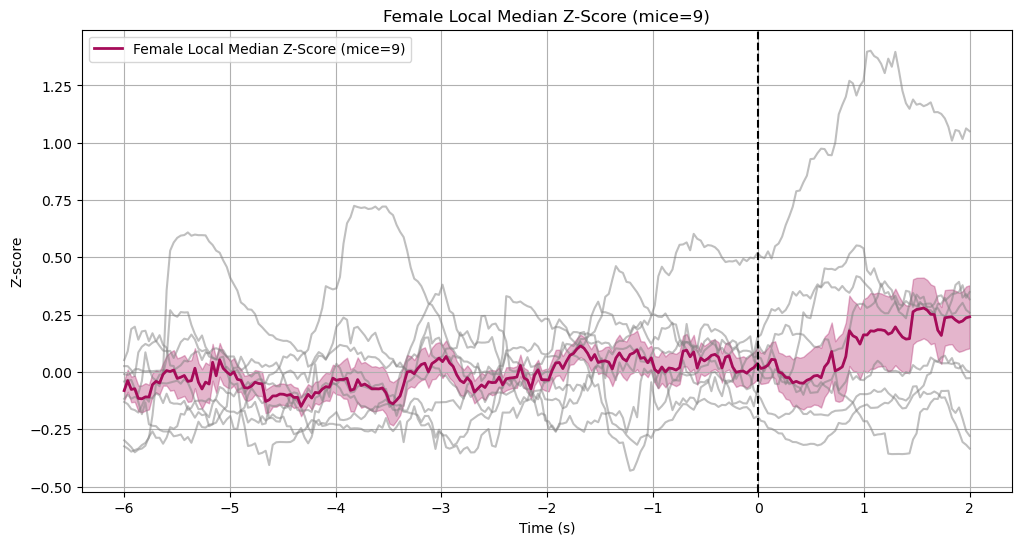

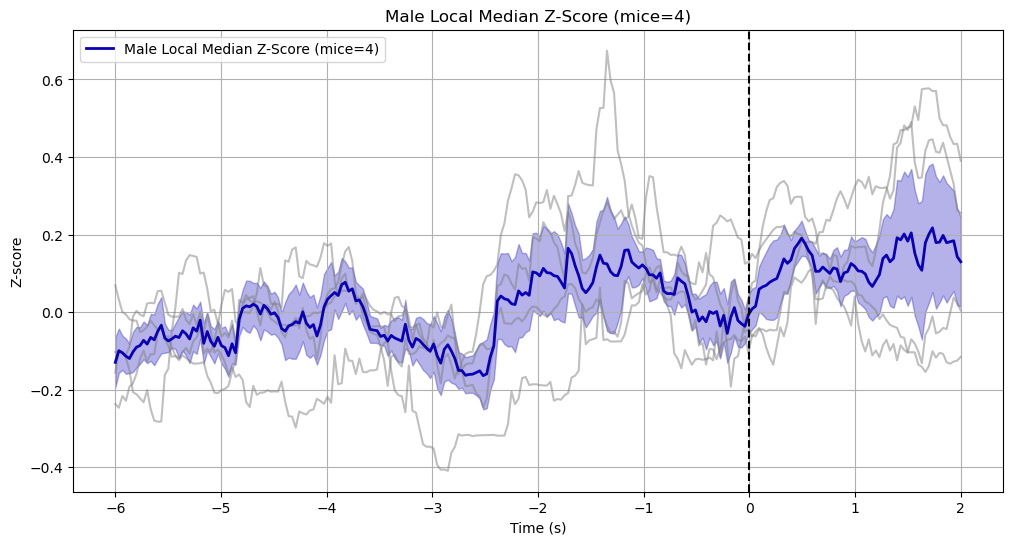

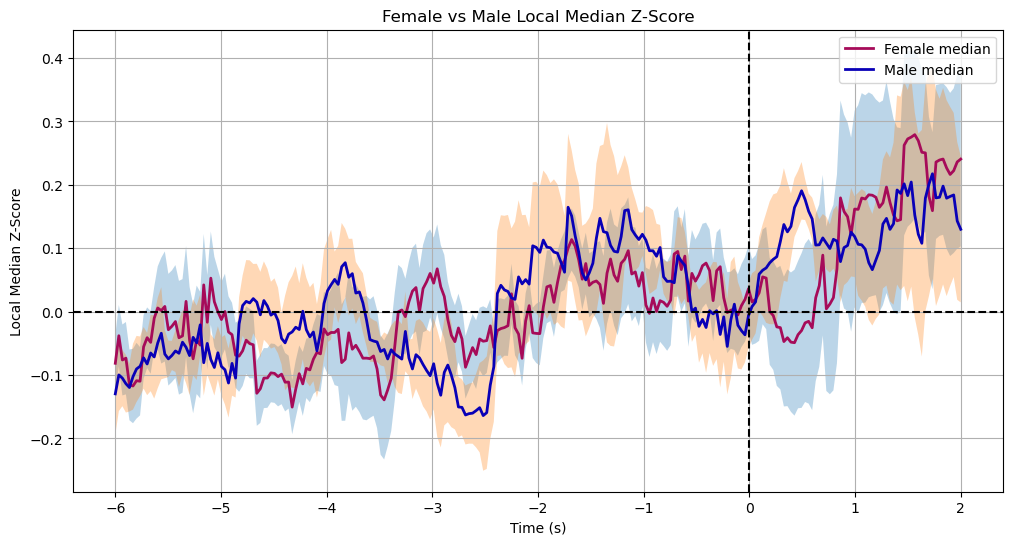

Bin	TimeRange	MeanDiff(Female-Male)	P_uncorrected	P_corrected
0	-6.00--5.80s	0.012	0.868	0.922
1	-5.77--5.56s	0.047	0.553	0.922
2	-5.53--5.33s	0.084	0.385	0.922
3	-5.30--5.10s	0.051	0.604	0.922
4	-5.06--4.86s	0.074	0.325	0.922
5	-4.83--4.63s	-0.046	0.566	0.922
6	-4.59--4.39s	-0.046	0.538	0.922
7	-4.36--4.16s	-0.044	0.659	0.922
8	-4.13--3.92s	0.014	0.89	0.922
9	-3.89--3.69s	0.011	0.922	0.922
10	-3.66--3.46s	0.056	0.588	0.922
11	-3.42--3.22s	0.077	0.383	0.922
12	-3.19--2.99s	0.158	0.119	0.922
13	-2.95--2.75s	0.121	0.255	0.922
14	-2.72--2.52s	0.121	0.148	0.922
15	-2.49--2.28s	0.047	0.681	0.922
16	-2.25--2.05s	-0.056	0.65	0.922
17	-2.02--1.82s	-0.085	0.51	0.922
18	-1.78--1.58s	-0.051	0.649	0.922
19	-1.55--1.35s	-0.108	0.439	0.922
20	-1.31--1.11s	-0.135	0.347	0.922
21	-1.08--0.88s	-0.086	0.3	0.922
22	-0.85--0.64s	0.009	0.907	0.922
23	-0.61--0.41s	0.087	0.329	0.922
24	-0.38--0.18s	0.046	0.65	0.922
25	-0.14-0.06s	0.033	0.7	0.922
26	0.09-0.29s	-0.027	0.829	0.922
27	0.33-0.53s	-0.070	0.588	0.92

In [39]:
# =========================
# Female vs Male ANALYSIS
# (drop-in: mirrors WT/KO)
# =========================

def group_experiments_by_sex(experiments):
    """Group experiments by Sex using tolerant parsing."""
    females, males = [], []
    for exp in experiments:
        s = str(getattr(exp, "Sex", "")).strip().lower()
        if s in {"f", "female", "♀", "woman", "girl"}:
            females.append(exp)
        elif s in {"m", "male", "♂", "man", "boy"}:
            males.append(exp)
        else:
            print(f"Warning: unknown/blank sex for {getattr(exp, 'Mouse_id', 'UNK')}: {getattr(exp, 'Sex', None)}")
    print(f"Female mice: {len(females)}, Male mice: {len(males)}")
    return females, males

# -------------------------
# Average-based analysis
# -------------------------
print("\n=== Female vs Male (Average-based) ===")
exps_sex = load_experiments(data_folder)
for exp in exps_sex:
    exp.smooth_grooming_bouts_generator(threshold=45)

Females, Males = group_experiments_by_sex(exps_sex)
exp_dict_sex = {e.Mouse_id: e for e in exps_sex}

# Settings (mirror your WT/KO block)
MIN_LEN, MAX_LEN = 2, 300
PRE_TIME_SEX = 6  # keep consistent with your earlier PRE_TIME
common_t_sex = np.linspace(-PRE_TIME_SEX, MIN_LEN, int((PRE_TIME_SEX + MIN_LEN) * FRAME_RATE))

# Raw analysis (mirror)
_, raw_bouts_F = detect_medium_bouts(Females, MIN_LEN, MAX_LEN)
_, raw_bouts_M = detect_medium_bouts(Males,   MIN_LEN, MAX_LEN)
fb_F, ft_F = filter_by_pre_activity(Females, raw_bouts_F, PRE_TIME_SEX)
fb_M, ft_M = filter_by_pre_activity(Males,   raw_bouts_M, PRE_TIME_SEX)
al_F = align_traces(ft_F, fb_F)
al_M = align_traces(ft_M, fb_M)

# Local avg z-score (mirror)
loc_F, lgavg_F, lgsem_F = compute_local_average_zscore(al_F, common_t_sex, -PRE_TIME_SEX, MIN_LEN)
loc_M, lgavg_M, lgsem_M = compute_local_average_zscore(al_M, common_t_sex, -PRE_TIME_SEX, MIN_LEN)

# Stats in 0.25s bins (mirror)
bin_size = int(0.25 * FRAME_RATE)
F_mat = np.vstack(list(loc_F.values())) if len(loc_F) else np.empty((0, len(common_t_sex)))
M_mat = np.vstack(list(loc_M.values())) if len(loc_M) else np.empty((0, len(common_t_sex)))
n_bins = min(F_mat.shape[1], M_mat.shape[1]) // bin_size if F_mat.size and M_mat.size else 0

p_vals = []
bin_indices = []
for i in range(n_bins):
    start = i * bin_size
    end   = start + bin_size
    F_bin_avg = F_mat[:, start:end].mean(axis=1)
    M_bin_avg = M_mat[:, start:end].mean(axis=1)
    _, p = ttest_ind(F_bin_avg, M_bin_avg, equal_var=False)
    p_vals.append(p)
    bin_indices.append((start, end))

_, p_corr, _, _ = multipletests(p_vals, method='fdr_bh') if p_vals else (None, np.array([]), None, None)
sig_mask = p_corr < 0.1 if p_vals else np.array([])

# Counts
F_n_mice   = len(loc_F)
F_n_traces = sum(len(trs) for trs in al_F.values())
M_n_mice   = len(loc_M)
M_n_traces = sum(len(trs) for trs in al_M.values())

# Per-group plots (mirror)
if lgavg_F is not None:
    plot_traces(
        common_t_sex,
        loc_F,
        lgavg_F,
        lgsem_F,
        title=f"Female Local Avg Z-Score (mice={F_n_mice}, bouts={F_n_traces})",
        color='#A60B59'
    )

if lgavg_M is not None:
    plot_traces(
        common_t_sex,
        loc_M,
        lgavg_M,
        lgsem_M,
        title=f"Male Local Avg Z-Score (mice={M_n_mice}, bouts={M_n_traces})",
        color='#0900B7'
    )

# Combined plot (mirror)
if (lgavg_F is not None) and (lgavg_M is not None):
    plt.figure(figsize=(12,6))
    plt.plot(common_t_sex, lgavg_F, color='#A60B59', linewidth=2,
             label=f"Female group (mice={F_n_mice}, bouts={F_n_traces})")
    plt.fill_between(common_t_sex, lgavg_F-lgsem_F, lgavg_F+lgsem_F, color='#A60B59', alpha=0.3)

    plt.plot(common_t_sex, lgavg_M, color='#0900B7', linewidth=2,
             label=f"Male group (mice={M_n_mice}, bouts={M_n_traces})")
    plt.fill_between(common_t_sex, lgavg_M-lgsem_M, lgavg_M+lgsem_M, color='#0900B7', alpha=0.3)

    for (start, end), sig in zip(bin_indices, sig_mask):
        if sig:
            center_time = common_t_sex[start:end].mean()
            ymax = max(lgavg_F[start:end].max(), lgavg_M[start:end].max()) + 0.05
            plt.plot(center_time, ymax, '*', color='black')

    plt.axvline(0, linestyle='--', color='grey')
    plt.axhline(0, linestyle='--', color='grey')
    plt.xlabel('Time (s)')
    plt.ylabel('Z-Score (GCaMP8s)')
    plt.legend()
    plt.show()

# Post-hoc summary (mirror)
if p_vals:
    print("Bin\tTimeRange\tMeanDiff(Female-Male)\tP_uncorrected\tP_corrected")
    for idx, (start, end) in enumerate(bin_indices):
        F_mean    = F_mat[:, start:end].mean()
        M_mean    = M_mat[:, start:end].mean()
        diff      = F_mean - M_mean
        time_range = f"{common_t_sex[start]:.2f}-{common_t_sex[end-1]:.2f}s"
        print(f"{idx}\t{time_range}\t{diff:.3f}\t{p_vals[idx]:.3g}\t{p_corr[idx]:.3g}")

# -------------------------
# Median-based analysis
# -------------------------
print("\n=== Female vs Male (Median-based) ===")
# Reuse al_F, al_M and common_t_sex from above
loc_med_F, mgavg_F, mgsem_F = compute_local_median_zscore(al_F, common_t_sex, -PRE_TIME_SEX, MIN_LEN)
loc_med_M, mgavg_M, mgsem_M = compute_local_median_zscore(al_M, common_t_sex, -PRE_TIME_SEX, MIN_LEN)

# Stats in 0.25s bins (mirror)
bin_size = int(0.25 * FRAME_RATE)
F_med_mat = np.vstack(list(loc_med_F.values())) if len(loc_med_F) else np.empty((0, len(common_t_sex)))
M_med_mat = np.vstack(list(loc_med_M.values())) if len(loc_med_M) else np.empty((0, len(common_t_sex)))
n_bins = min(F_med_mat.shape[1], M_med_mat.shape[1]) // bin_size if F_med_mat.size and M_med_mat.size else 0

p_vals_med = []
bin_indices_med = []
for i in range(n_bins):
    start = i * bin_size
    end   = start + bin_size
    F_bin_avg = F_med_mat[:, start:end].mean(axis=1)
    M_bin_avg = M_med_mat[:, start:end].mean(axis=1)
    _, p = ttest_ind(F_bin_avg, M_bin_avg, equal_var=False)
    p_vals_med.append(p)
    bin_indices_med.append((start, end))

_, p_corr_med, _, _ = multipletests(p_vals_med, method='fdr_bh') if p_vals_med else (None, np.array([]), None, None)
sig_mask_med = p_corr_med < 0.1 if p_vals_med else np.array([])

# Plot per-group median traces (mirror)
if mgavg_F is not None:
    plot_traces(
        common_t_sex,
        loc_med_F,
        mgavg_F,
        mgsem_F,
        title=f"Female Local Median Z-Score (mice={len(loc_med_F)})",
        color='#A60B59'
    )

if mgavg_M is not None:
    plot_traces(
        common_t_sex,
        loc_med_M,
        mgavg_M,
        mgsem_M,
        title=f"Male Local Median Z-Score (mice={len(loc_med_M)})",
        color='#0900B7'
    )

# Combined median comparison (mirror)
if (mgavg_F is not None) and (mgavg_M is not None):
    plt.figure(figsize=(12,6))
    plt.plot(common_t_sex, mgavg_F, linewidth=2, label='Female median', color='#A60B59')
    plt.fill_between(common_t_sex, mgavg_F-mgsem_F, mgavg_F+mgsem_F, alpha=0.3)

    plt.plot(common_t_sex, mgavg_M, linewidth=2, label='Male median', color='#0900B7')
    plt.fill_between(common_t_sex, mgavg_M-mgsem_M, mgavg_M+mgsem_M, alpha=0.3)

    plt.axvline(0, linestyle='--', color='k')
    plt.axhline(0, linestyle='--', color='k')
    plt.xlabel('Time (s)')
    plt.ylabel('Local Median Z-Score')
    plt.title('Female vs Male Local Median Z-Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Post-hoc summary (mirror)
if p_vals_med:
    print("Bin\tTimeRange\tMeanDiff(Female-Male)\tP_uncorrected\tP_corrected")
    for idx, (start, end) in enumerate(bin_indices_med):
        F_mean    = F_med_mat[:, start:end].mean()
        M_mean    = M_med_mat[:, start:end].mean()
        diff      = F_mean - M_mean
        time_range = f"{common_t_sex[start]:.2f}-{common_t_sex[end-1]:.2f}s"
        print(f"{idx}\t{time_range}\t{diff:.3f}\t{p_vals_med[idx]:.3g}\t{p_corr_med[idx]:.3g}")
